copied from https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

# 환경 준비

In [7]:
!pip install --upgrade tf-keras-vis matplotlib

Requirement already up-to-date: tf-keras-vis in /usr/local/lib/python3.6/dist-packages (0.5.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.1)


In [8]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

In [19]:
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm

# 모델 로딩

VGG16을 사용한다.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 데이터 준비

In [10]:
%%shell

wget https://github.com/keisen/tf-keras-vis/raw/master/examples/images/goldfish.jpg
wget https://github.com/keisen/tf-keras-vis/raw/master/examples/images/bear.jpg
wget https://github.com/keisen/tf-keras-vis/raw/master/examples/images/soldiers.jpg

--2020-08-16 10:13:22--  https://github.com/keisen/tf-keras-vis/raw/master/examples/images/goldfish.jpg
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/examples/images/goldfish.jpg [following]
--2020-08-16 10:13:22--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg.2’

goldfish.jpg.2      100%[===================>]   8.63K  --.-KB/s    in 0s      

2020-08-16 10:13:22 (45.1 MB/s) - ‘goldfish.jpg.2’ saved [8833/8833]

--2020-08-16 10:13:

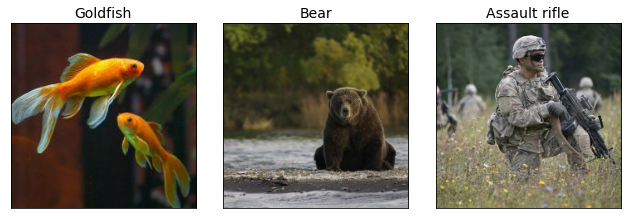

In [11]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Load images
img1 = load_img('goldfish.jpg', target_size=(224, 224))
img2 = load_img('bear.jpg', target_size=(224, 224))
img3 = load_img('soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data
X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

# CAM 사용위한 loss, model_modifier 준비

In [13]:
GOLDFISH_CATEGORY_INDEX = 1
BEAR_CATEGORY_INDEX = 294
ASSAULT_RIFLE_CATEGORY_INDEX = 413

def loss(output):
    return (output[0][GOLDFISH_CATEGORY_INDEX], output[1][BEAR_CATEGORY_INDEX], output[2][ASSAULT_RIFLE_CATEGORY_INDEX
])

모델의 마지막 레이어의 활성화함수를 softmax인경우 linear로 변경하여야 한다.

In [14]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# GradCAM++ 실행

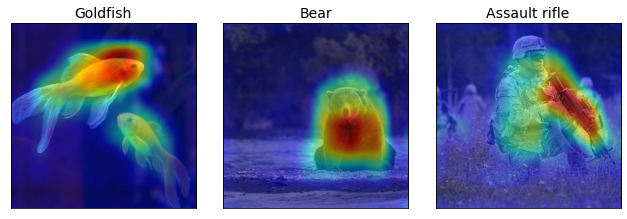

In [21]:
from tf_keras_vis.gradcam import GradcamPlusPlus

gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

TARGET_LAYER_NUMBER = -1 # 마지막 층
# Generate heatmap with GradCAM++
cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

# Faster-ScoreCAM 실행

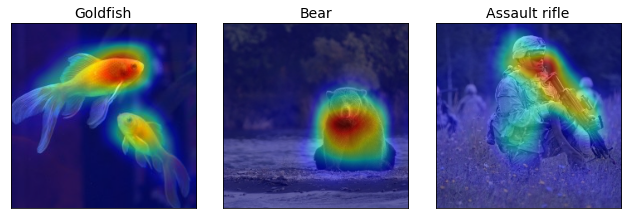

In [25]:
from tf_keras_vis.scorecam import ScoreCAM

scorecam = ScoreCAM(model, model_modifier, clone=False)

TARGET_LAYER_NUMBER = -1 # 마지막 층
cam = scorecam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER, max_N=10)

cam = normalize(cam)



f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()